# Web Research (STORM)

`STORM` is a research assistant designed by Shao, et. al that extends the idea of "outline-driven RAG" for richer article generation.  
STORM is designed to generate Wikipedia-style ariticles on a user-provided topic. It applies two main insights to produce more organized and comprehensive articles:

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
%%capture --no-stderr
%pip install -U langchain_community langchain_openai langchain_fireworks langgraph wikipedia duckduckgo-search tavily-python

# Select LLM model

In [2]:
from langchain_openai import ChatOpenAI

fast_llm = ChatOpenAI(model_name="gpt-4o-mini")
long_context_llm = ChatOpenAI(model_name="gpt-4o")


In [3]:
from typing import List,Optional
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        
     (
        "system",
        "You are a Wikipedia writer. Write an outline for a Wikipedia page about a user-provided topic. Be comprehensive and specific.",
     ),
     ("user", "{topic}"),   
    ]
)
class Subsection(BaseModel):
    subsection_title: str = Field(..., title='Title of the subsection')
    description: str = Field(..., title="Content of the subsection")

    @property
    def as_str(self) -> str:
        return f'###{self.subsection_title}\n\n{self.description}'.strip()
    
class Section(BaseModel):
    section_title: str = Field(..., title='Title of the section')
    description: str = Field(..., title="Content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title='Titles and descriptions for each subsection of the Wikipeida page.'
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"###{subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )
        return f"##{self.section_title}\n\n{self.description}\n\n{subsections}".strip()
    
class Outline(BaseModel):
    page_title: str = Field(..., title='Title of the Wikipedia page')
    sections: List[Section] = Field(
        default_factory=list,
        title='Titles and descriptions for each section of the Wikipedia page.',
    )
    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()
    
generate_outline_direct = direct_gen_outline_prompt | fast_llm.with_structured_output(Outline)

In [4]:
example_topic = "Creating LLM which can generate answers in Kazakh language"

initial_outline = generate_outline_direct.invoke({"topic": example_topic})
print(initial_outline.as_str)

# Kazakh Language Large Language Model (LLM) Development

##Introduction

An overview of what Large Language Models (LLMs) are and their significance in language processing. This section will introduce the concept of developing LLMs specifically tailored for the Kazakh language, addressing the need for better language representation and processing in AI.

###What is a Large Language Model?

Definition and characteristics of LLMs, with examples of popular models like GPT, BERT, and others.

###Importance of Kazakh Language Processing

Discuss the growing need for AI tools in minority languages, specifically the Kazakh language, in education, government, and cultural preservation.

##Challenges in Kazakh Language LLM Development

A detailed exploration of the unique challenges faced when creating an LLM for the Kazakh language.

###Linguistic Diversity and Complexity

Overview of the grammatical structure, vocabulary, and dialects of Kazakh that complicate LLM training.

###Data Availabi

# Expand Topics

In [5]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """I'm writing a Wikipedia page for a topic mentioned below. \
    Please identify and recommend some Wikipedia pages on closely related subjects. \
    I'm looking for examples that provide insights into interesting aspects commonly associated with this topic, \
    or examples that help me understand the typical content and structure included in Wikipedia pages for similar topics. \
    Please list the as many subjects and urls as you can.   \
    Topic of interest: {topic}
"""
)

class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="Comprehensive list of related subjects as background research.",
    )

expand_chain = gen_related_topics_prompt | fast_llm.with_structured_output(RelatedSubjects)

In [6]:
related_subjects = await expand_chain.ainvoke({"topic": example_topic})


# Generate Perspectives

In [7]:
class Editor(BaseModel):
    affilation: str = Field(
        description="Primary affilation of the editor.",
    )
    name: str = Field(
        description="Name of the editor.",
    )
    role: str = Field(
        description="Role of the editor in the context of the topic.",
    )
    description: str = Field(
        description="Description of the editor's focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffilation: {self.affilation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    editors: List[Editor]= Field(
        description="Comprehensive list of editors with their roles and affiliations.",
        # Add a pydantic validation/restriction to be at most M editors
    )
gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You need to select a diverse (and distinct) group of Wikipedia editors who will work together to create a comprehensive article on the topic.\
                Each of them represents a different perspective, role, or affiliation related to this topic.\
            You can use other Wikipedia pages of related topics for inspiration. For each editor, add a description of what they will focus on.\
            Wiki page outlines of related topics for inspiration: {examples}""",
        ),
        ("user", "Topic of interest: {topic}")
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | ChatOpenAI(model_name="gpt-4o-mini").with_structured_output(Perspectives)



In [8]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables import chain as as_runnable

wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)

def format_doc(doc, max_length=1000):
    related = "- ".join(doc.metadata['categories'])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[:max_length]

def format_docs(docs):
    return "\n\n".join(format_doc(doc) for doc in docs)

@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({"topic": topic})
    retrieved_docs = await wikipedia_retriever.abatch(
        related_subjects.topics, return_exceptions=True
    )
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({"examples": formatted, "topic": topic})


In [9]:
perspectives = await survey_subjects.ainvoke(example_topic)
perspectives.dict()

/var/folders/p8/wg2_6tz10x111q372jxw6ghc0000gn/T/ipykernel_66443/35571063.py:2: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  perspectives.dict()


{'editors': [{'affilation': 'Kazakh Linguistic Institute',
   'name': 'Ayman Kairbekova',
   'role': 'Linguist',
   'description': 'Focuses on the linguistic properties of the Kazakh language, including grammatical structure, colloquialisms, and regional dialects. She will ensure that the generated content adheres to the rules of Kazakh syntax and vocabulary, and that it reflects cultural nuances.'},
  {'affilation': 'OpenAI',
   'name': 'Dr. Askar Jonbekov',
   'role': 'AI Researcher',
   'description': 'Works on applying large language models in multilingual contexts. His expertise lies in adapting LLMs for underrepresented languages like Kazakh. He will emphasize the methodology of fine-tuning existing LLMs to capture Kazakh language features.'},
  {'affilation': 'University of Almaty',
   'name': 'Bota Suleimenova',
   'role': 'Computational Linguist',
   'description': 'Her research specializes in developing language resources for Kazakh, such as corpora and lexical databases. She

# Expert Dialog

## Interview State

In [10]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START

def add_message(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right

def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references

def update_editor(editor, new_editor):
    # Can only set at the outset
    if not editor:
        return new_editor
    return editor

class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_message]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]


## Dialog Roles

In [28]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_core.prompts import MessagesPlaceholder

gen_qn_prompt = ChatPromptTemplate.from_messages(
        [
            (
    "system",
            """You are an experienced Wikipedia writer and want to edit a specific page. \
            Besides your identity as a Wikipedia writer, you have a specific focus when researching the topic. \
            Now, you are chatting with an expert to get information. Ask good questions to get more useful information.  \
            When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation.\
            Please only ask one question at a time and don't ask what you have asked before.\
            Your questions should be related to the topic you want to write.
            Be comprehensive and curious, gaining as much unique insight from the expert as possible.\
            Stay true to your specific perspective: {persona}""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
        ]
    )

def tag_with_name(ai_message: AIMessage, name: str):
    valid_name = ''.join(c for c in name if c.isalnum() or c in ['_', '-'])
    ai_message.name = valid_name
    return ai_message

def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state['messages']:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.model_dump(exclude={"type"}))
        converted.append(message)
    return {"messages": converted}

@as_runnable
async def generate_question(state: InterviewState):
    editor = state["editor"]
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | fast_llm
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {"messages": [result]}

In [29]:
messages = [
    HumanMessage(f"So you said you were writing an article on {example_topic}?")
]
question = await generate_question.ainvoke(
    {
        "editor": perspectives.editors[0],
        "messages": messages,
    }
)
question["messages"][0].content

'I’m actually focused on enhancing content related to the linguistic properties of the Kazakh language, including its grammatical structure and regional dialects. What specific aspects of Kazakh syntax or colloquialisms do you think are most important for a language model to understand in order to generate natural Kazakh text?'

In [30]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="Comprehensive list of search engine queries to answer the user's questions.",
    )
gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful research assistant. Query the search engine to answer the user's questions.",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)
gen_queries_chain = gen_queries_prompt | ChatOpenAI(
    model_name="gpt-4o-mini"
).with_structured_output(Queries, include_raw=True)

In [31]:
queries = await gen_queries_chain.ainvoke(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
queries['parsed'].queries

['Kazakh language grammatical structure',
 'Kazakh syntax rules',
 'Kazakh language regional dialects',
 'important aspects of Kazakh syntax',
 'colloquial expressions in Kazakh',
 'Kazakh language morphological features',
 'Kazakh sentence structure variations',
 'Kazakh verb conjugation rules',
 'Kazakh noun cases and usage',
 'Kazakh language idiomatic expressions',
 'differences between Kazakh dialects',
 'Kazakh language punctuation rules',
 'Kazakh prepositions and their usage',
 'impact of regional dialects on Kazakh written language',
 'language model training for Kazakh text generation']

In [32]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="Comprehensive answer to the user's question with citations.",
    )
    cited_urls: List[str] = Field(
        description="List of urls cited in the answer",
    )
    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\nCitations:\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls)
        )
gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert who can use information effectively. You are chatting with a Wikipedia writer who wants\
                to write a Wikipedia page on the topic you know. You have gathered the related information and will now use the information to form a response.\
            Make your response as informative as possible and make sure every sentence is supported by the gathered information.\
Each response must be backed up by a citation from a reliable source, formatted as a footnote, reproducing the URLS after your response.""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | fast_llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(run_name="GenerateAnswer")

In [33]:
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.tools import tool

search_engine = DuckDuckGoSearchAPIWrapper()

@tool
async def search_engine(query: str) -> str:
    """Search engine to the internet."""
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return [{"content": r["body"], "url": r['href']} for r in results]

In [34]:
import json
from langchain_core.runnables import RunnableConfig
async def gen_answer(
        state: InterviewState,
        config: Optional[RunnableConfig] = None,
        name: str = "Subject_Matter_Expert",
        max_str_len: int = 15000,
):
    valid_name = ''.join(c for c in name if c.isalnum() or c in ['_', '-'])
    swapped_state = swap_roles(state, valid_name) # Convert all other AI messages
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(
        queries['parsed'].queries, config, return_exceptions=True
    )
    successfull_results = [
        res for res in query_results if not isinstance(res, Exception)
    ]
    all_query_results = {
        res['url']: res['content'] for results in successfull_results for res in results
    }

    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries["raw"]
    
    # Check if tool_calls is not empty
    if ai_message.tool_calls:
        tool_call = ai_message.tool_calls[0]
        tool_id = tool_call["id"]
        tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
        swapped_state["messages"].extend([ai_message, tool_message])
    else:
        # Handle the case where tool_calls is empty
        print("Warning: No tool calls found in the AI message.")
        return {"messages": [ai_message], "references": {}}

    # Only update the shared state with the final answer to avoid
    # polluting the dialogue history with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated["parsed"].cited_urls)
    # Save the retrieved information to the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated["parsed"].as_str)
    return {"messages": [formatted_message], "references": cited_references}

In [35]:
example_answer  = await gen_answer(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
example_answer["messages"][-1].content

'{"queries":["Kazakh language grammatical structure","Kazakh syntax rules","Kazakh language regional dialects","Important colloquialisms in Kazakh","Kazakh sentence structure","Kazakh morphology and syntax","Common phrases in Kazakh dialects","Kazakh language phonetics and phonology","Differences between Kazakh dialects","Natural language processing in Kazakh","Kazakh verb conjugation patterns","Kazakh noun cases","Kazakh pronouns and their usage","Kazakh language idiomatic expressions","Contextual usage of Kazakh expressions","Language model training for Kazakh"]}'

## Construct the Interview Graph

In [36]:
max_num_turns = 5
from langgraph.pregel import RetryPolicy

def route_messages(state: InterviewState, name: str = "Subject_Matter_Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("Thank you so much for your help!"):
        return END
    return "ask_question"

builder = StateGraph(InterviewState)
builder.add_node("ask_question", generate_question, retry=RetryPolicy(max_attempts=5))
builder.add_node("answer_question", gen_answer, retry=RetryPolicy(max_attempts=5))
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")


builder.add_edge(START, "ask_question")
interview_graph = builder.compile(checkpointer=False).with_config(run_name="Conduct Interviews")

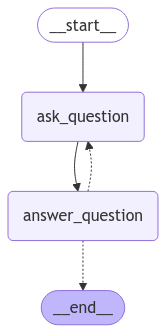

In [37]:
from IPython.display import Image, display
try:
    display(Image(interview_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [ ]:
final_step = None
initial_state = {
    "editor": perspectives.editors[0],
    "messages": [
        AIMessage(
            content=f"So you said you were writing an article on {example_topic}?",
            name="Subject_Matter_Expert",
        )
    ],

}
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print("--", str(step[name]['messages'])[:300])
final_step = step

In [ ]:
final_state = next(iter(final_step.values()))


# Refine Outline

In [ ]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a Wikipedia writer. You have gathered information from experts and search engines. \
                Now, you are refining the outline of the Wikipedia page. \
                You need to make sure that the outline is comprehensive and specific. \
                Topic you are writing about: {topic} \
                Old outline: {old_outline}""",
        ),
        
    ]
)